In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import lime.lime_tabular
import shap
from sklearn.inspection import PartialDependenceDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from interpret.glassbox import ExplainableBoostingClassifier
from interpret import show
from sklearn.model_selection import train_test_split
from FileDAT import FileDAT
from sklearn.metrics import confusion_matrix
from DatasetAnalysis import DatasetAnalysis
from PerformanceAnalysis import PerformanceAnalysis

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


# Setup

In [2]:
config_file = open('config.json')
config_vars = json.load(config_file)
config_file.close()

logs_dir = config_vars["logs_dir"]

In [3]:
config_file = open('visual_config.json')
visual_vars = json.load(config_file)
config_file.close()

shap_colors_neg = visual_vars["shap_colors"]["negative"]
shap_colors_pos = visual_vars["shap_colors"]["positive"]
shap_colors = np.array([tuple(shap_colors_neg), tuple(shap_colors_pos)])

title_size = visual_vars["title_font_size"]
label_size = visual_vars["labels_font_size"]

green_color = tuple([x/255 for x in visual_vars["green_colors"]["c2"]])

## Get Dataset

In [4]:
dataset = FileDAT("./datasets/pima.dat")
dataset.open()
dataset.interpret()
print(dataset.get_data())
dataset.info()
features_names = dataset.get_header().iloc[:-1, 0]

[['14' '175' '62' ... '0.212' '38' 'tested_positive']
 ['4' '146' '78' ... '0.52' '67' 'tested_positive']
 ['15' '136' '70' ... '0.153' '43' 'tested_positive']
 ...
 ['7' '119' '0' ... '0.209' '37' 'tested_negative']
 ['1' '95' '66' ... '0.334' '25' 'tested_negative']
 ['1' '181' '64' ... '0.328' '38' 'tested_positive']]
Name of the dataset: pima


Attribute Name       Domain                              Range
0           Preg         real                         [0.0,17.0]
1           Plas         real                        [0.0,199.0]
2           Pres         real                        [0.0,122.0]
3           Skin         real                         [0.0,99.0]
4           Insu         real                        [0.0,846.0]
5           Mass         real                         [0.0,67.1]
6           Pedi         real                       [0.078,2.42]
7            Age         real                        [21.0,81.0]
8          Class  categorical  {tested_negative,tested_positive}

Number of features: 8
Number of instances: 768
Number of classes: 2


In [5]:
features_names

0    Preg
1    Plas
2    Pres
3    Skin
4    Insu
5    Mass
6    Pedi
7     Age
Name: Attribute Name, dtype: object

In [7]:
X = dataset.get_x()
y = dataset.get_y()

In [8]:
data_analysis = DatasetAnalysis()

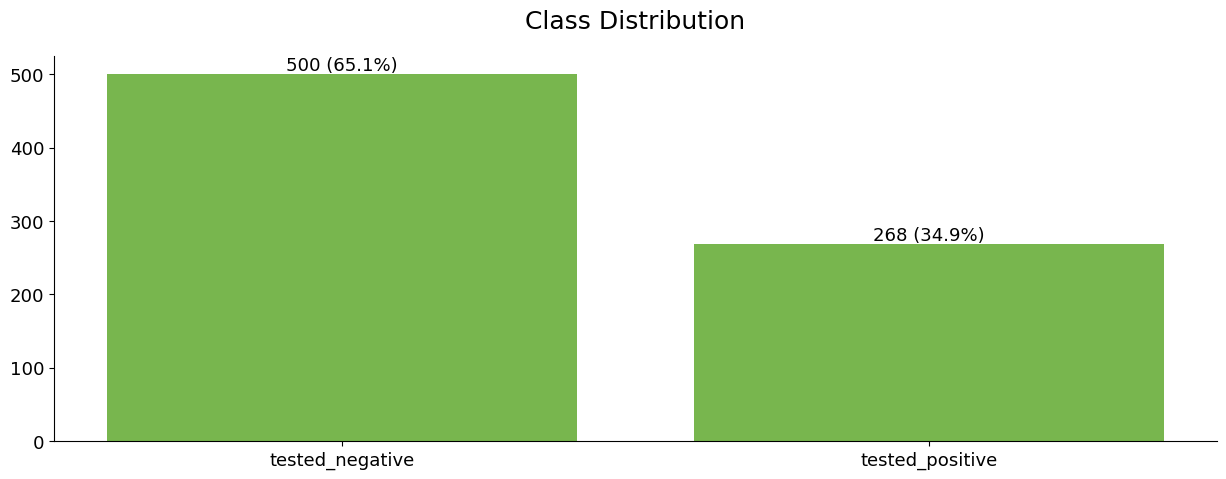

In [9]:
plt.figure(figsize=(15, 5))

data_analysis.class_dist(y, title="Class Distribution", colors=green_color, label_font_size=label_size)

plt.savefig(f"{logs_dir}/pima_class_dist.png", bbox_inches="tight")
plt.show()

In [70]:
X_train, X_test, Y_train, Y_test = train_test_split(
    dataset.get_x(),dataset.get_y(), test_size=0.25, random_state=111
)
X_train = X_train.astype(float)
X_test = X_test.astype(float)
Y_train = Y_train.reshape((len(Y_train)))
Y_train = [0 if x == "tested_negative" else 1 for x in Y_train]
Y_test = Y_test.reshape((len(Y_test)))
Y_test = [0 if x == "tested_negative" else 1 for x in Y_test]

In [71]:
X_train_pd = pd.DataFrame(X_train, columns=features_names)
X_test_pd = pd.DataFrame(X_test, columns=features_names)

In [72]:
X_train_pd

Attribute Name  Preg   Plas  Pres  Skin   Insu  Mass   Pedi   Age
0                8.0   74.0  70.0  40.0   49.0  35.3  0.705  39.0
1               11.0  138.0  74.0  26.0  144.0  36.1  0.557  50.0
2                4.0  103.0  60.0  33.0  192.0  24.0  0.966  33.0
3                1.0   95.0  82.0  25.0  180.0  35.0  0.233  43.0
4               10.0  101.0  86.0  37.0    0.0  45.6  1.136  38.0
..               ...    ...   ...   ...    ...   ...    ...   ...
571              7.0  109.0  80.0  31.0    0.0  35.9  1.127  43.0
572              2.0  122.0  70.0  27.0    0.0  36.8  0.340  27.0
573              2.0   88.0  74.0  19.0   53.0  29.0  0.229  22.0
574              0.0  188.0  82.0  14.0  185.0  32.0  0.682  22.0
575             10.0  122.0  78.0  31.0    0.0  27.6  0.512  45.0

[576 rows x 8 columns]

In [73]:
classes = np.unique(dataset.get_y(), return_counts=True)

[Text(0, 0, '500'), Text(0, 0, '268')]

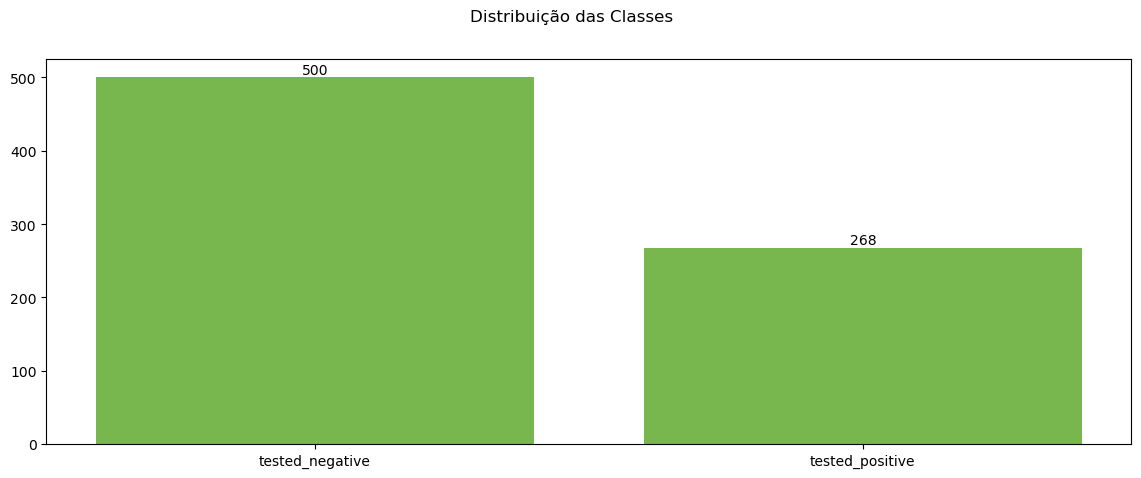

In [74]:
fig, ax = plt.subplots(figsize=(14, 5), ncols=1, nrows=1)
fig.suptitle('Distribuição das Classes')

c1 = (169/255,209/255,142/255)
c2 = (120/255, 182/255, 78/255)
c3 = (84/255, 130/255, 53/255)

ax.bar(classes[0], classes[1], color=c2)

ax.bar_label(ax.containers[0], labels=classes[1], label_type='edge', fontsize=10)
    

# Classification

## Train the Model - <i>Logistic Regression</i> (LR)

In [75]:
lr_clf = LogisticRegression(max_iter=2000).fit(X_train, Y_train)

Metrics                Values
accuracy             0.791667
false-positive rate  0.120968
false-negative rate  0.367647
precision            0.741379
recall               0.632353
f-score              0.682540

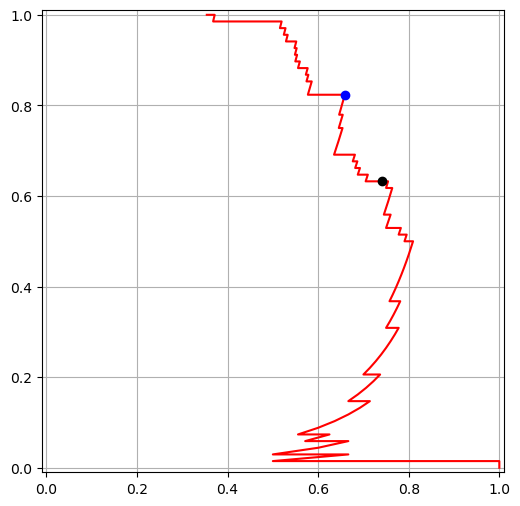

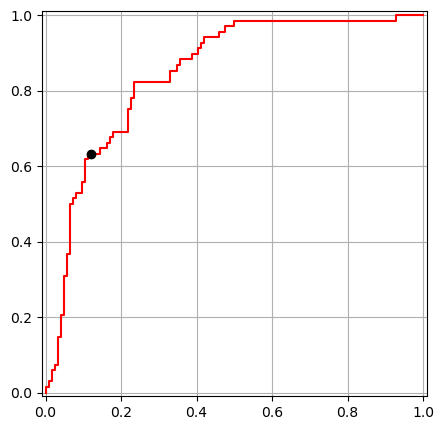

In [76]:
lr_ye = lr_clf.predict(X_test)
lr_cm = confusion_matrix(Y_test, lr_ye)
display(compute_metrics(lr_cm))

lr_y2d = lr_clf.predict_proba(X_test)[:, 1]
plot_PR(Y_test, lr_cm, lr_y2d)
plot_ROC(Y_test, lr_cm, lr_y2d)

In [77]:
print(f"Instância:\n {X_test[0, :]}\n\nClasse: {Y_test[0]}")

Instância:
 [2.00e+00 1.14e+02 6.80e+01 2.20e+01 0.00e+00 2.87e+01 9.20e-02 2.50e+01]

Classe: 0


## Extract Explanations

### <i>Local Model-Agnostic Explanations</i> (LIME)

In [78]:
lr_LIME_explainer = lime.lime_tabular.LimeTabularExplainer(X_train, feature_names=features_names)
lr_LIME_explanation = lr_LIME_explainer.explain_instance(X_test[0], lr_clf.predict_proba)

In [79]:
lr_LIME_explanation.show_in_notebook(show_table=True)

In [80]:
lr_LIME_explanation.local_pred

array([0.12684238])

### <i>SHapley Additive exPlanations</i> (SHAP)

#### Convert X in pandas dataframe

In [81]:
shap.initjs()

In [82]:
X_test_pd.iloc[0, :], Y_test[0],X_train_pd

(Attribute Name
 Preg      2.000
 Plas    114.000
 Pres     68.000
 Skin     22.000
 Insu      0.000
 Mass     28.700
 Pedi      0.092
 Age      25.000
 Name: 0, dtype: float64,
 0,
 Attribute Name  Preg   Plas  Pres  Skin   Insu  Mass   Pedi   Age
 0                8.0   74.0  70.0  40.0   49.0  35.3  0.705  39.0
 1               11.0  138.0  74.0  26.0  144.0  36.1  0.557  50.0
 2                4.0  103.0  60.0  33.0  192.0  24.0  0.966  33.0
 3                1.0   95.0  82.0  25.0  180.0  35.0  0.233  43.0
 4               10.0  101.0  86.0  37.0    0.0  45.6  1.136  38.0
 ..               ...    ...   ...   ...    ...   ...    ...   ...
 571              7.0  109.0  80.0  31.0    0.0  35.9  1.127  43.0
 572              2.0  122.0  70.0  27.0    0.0  36.8  0.340  27.0
 573              2.0   88.0  74.0  19.0   53.0  29.0  0.229  22.0
 574              0.0  188.0  82.0  14.0  185.0  32.0  0.682  22.0
 575             10.0  122.0  78.0  31.0    0.0  27.6  0.512  45.0
 
 [576 rows x

In [83]:
lr_SHAP_exp = shap.KernelExplainer(lr_clf.predict_proba, shap.sample(X_train_pd, 100))
lr_shap_values = np.array(lr_SHAP_exp.shap_values(X_test_pd.iloc[0, :]))

In [84]:
shap.force_plot(lr_SHAP_exp.expected_value[1], lr_shap_values[:,1], X_test_pd.iloc[0, :])

  0%|          | 0/192 [00:00<?, ?it/s]

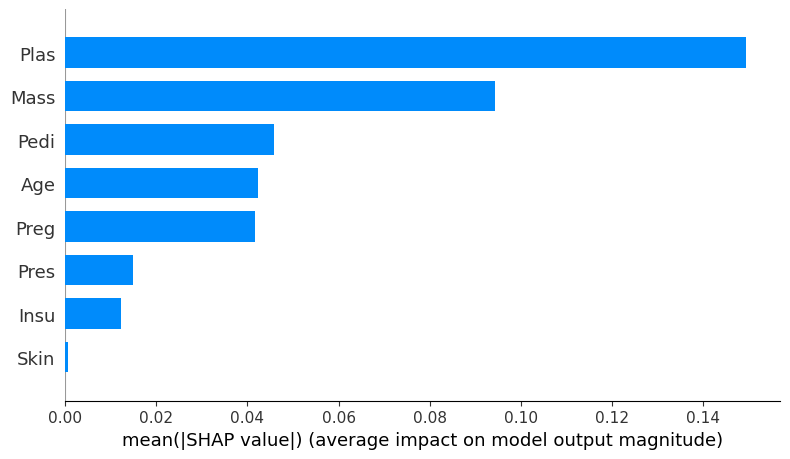

In [85]:
lr_shap_values = lr_SHAP_exp.shap_values(X_test_pd)
shap.summary_plot(lr_shap_values[:,:,1], X_test_pd, plot_type="bar")

## Train the Model - <i>Random Forest</i> (RF)

In [86]:
rf_clf = RandomForestClassifier().fit(X_train, Y_train)

Metrics                Values
accuracy             0.765625
false-positive rate  0.137097
false-negative rate  0.411765
precision            0.701754
recall               0.588235
f-score              0.640000

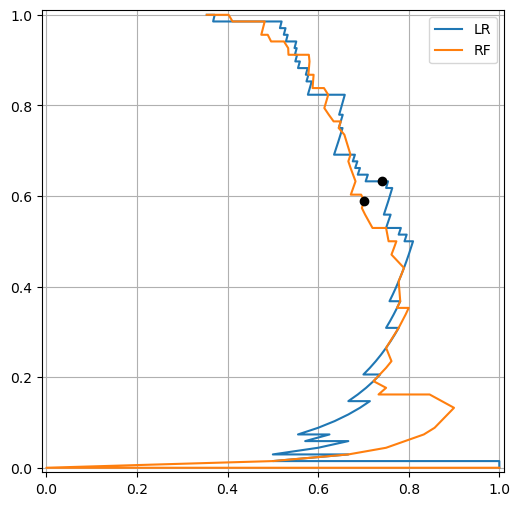

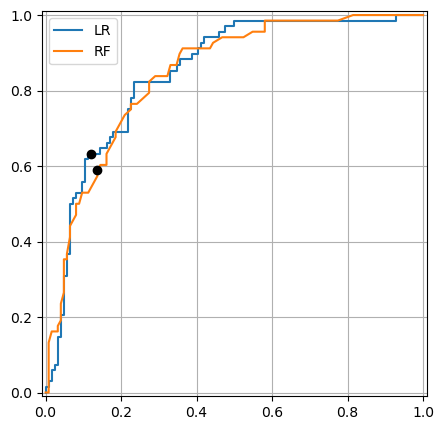

In [87]:
rf_ye = rf_clf.predict(X_test)

rf_cm = confusion_matrix(Y_test, rf_ye)
display(compute_metrics(rf_cm))

rf_y2d = rf_clf.predict_proba(X_test)[:, 1]
compare_PR([Y_test, Y_test], [lr_cm, rf_cm], [lr_y2d, rf_y2d], ["LR", "RF"])
compare_ROC([Y_test, Y_test], [lr_cm, rf_cm], [lr_y2d, rf_y2d], ["LR", "RF"])

## Extract Explanations


### <i>Local Model-Agnostic Explanations</i> (LIME)

In [88]:
rf_LIME_explainer = lime.lime_tabular.LimeTabularExplainer(X_train, feature_names=features_names)
rf_LIME_explanation = rf_LIME_explainer.explain_instance(X_test[0], rf_clf.predict_proba)

In [89]:
rf_LIME_explanation.show_in_notebook(show_table=True)

### <i>SHapley Additive exPlanations</i> (SHAP)

In [90]:
rf_SHAP_exp = shap.KernelExplainer(rf_clf.predict_proba, shap.sample(X_train_pd, 100))
rf_shap_values = np.array(rf_SHAP_exp.shap_values(X_test_pd.iloc[0, :]))

In [91]:
shap.force_plot(rf_SHAP_exp.expected_value[1], rf_shap_values[:,1], X_test_pd.iloc[0, :])

In [92]:
rf_shap_values

array([[ 0.03948321, -0.03948321],
       [ 0.0524175 , -0.0524175 ],
       [ 0.00550202, -0.00550202],
       [ 0.0181325 , -0.0181325 ],
       [-0.00742298,  0.00742298],
       [ 0.04190393, -0.04190393],
       [ 0.02491464, -0.02491464],
       [ 0.09896917, -0.09896917]])

In [93]:
rf_SHAP_exp.expected_value

array([0.6261, 0.3739])

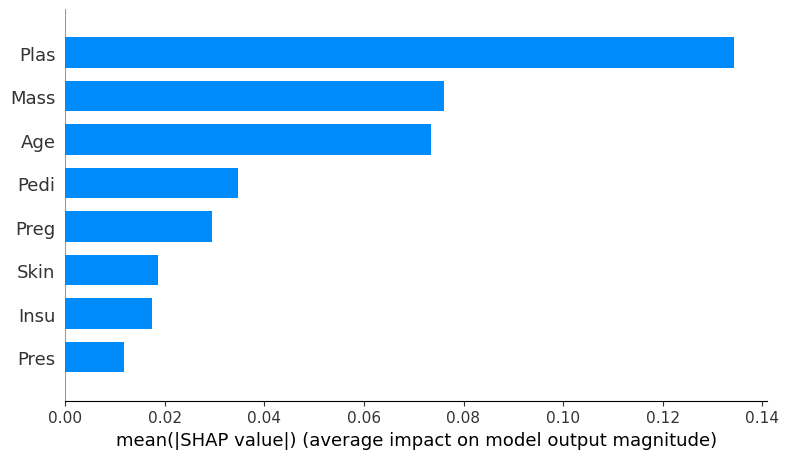

In [94]:
explainer = shap.Explainer(rf_clf)
rf_shap_values = explainer.shap_values(X_test_pd)
shap.summary_plot(rf_shap_values[:,:,1], X_test_pd, plot_type="bar")

In [96]:
f1 = list(features_names).index("Plas")
f2 = list(features_names).index("Mass")
f3 = list(features_names).index("Age")
f4 = list(features_names).index("Pres")
f5 = list(features_names).index("Skin")
f6 = list(features_names).index("Insu")
f7 = list(features_names).index("Pedi")
f8 = list(features_names).index("Preg")

1 5


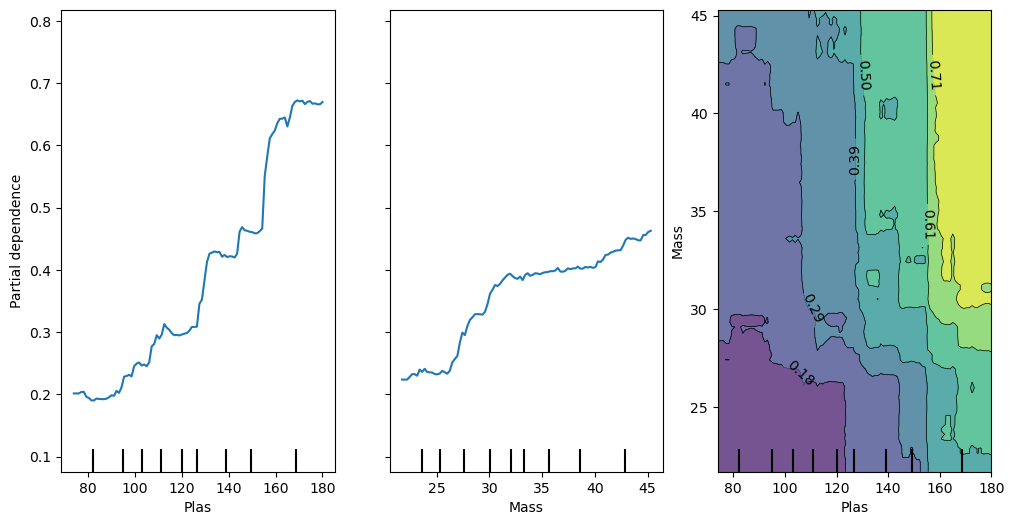

In [97]:
print(f1, f2)
features1 = [f1, f2, (f1, f2)]
fig, ax = plt.subplots(figsize=(12, 6))
PartialDependenceDisplay.from_estimator(rf_clf, X_test, features1, feature_names=features_names, ax=ax)

# Train SVM

In [98]:
svm_clf = SVC(kernel="linear", probability=True).fit(X_train, Y_train)

Metrics                Values
accuracy             0.796875
false-positive rate  0.120968
false-negative rate  0.352941
precision            0.745763
recall               0.647059
f-score              0.692913

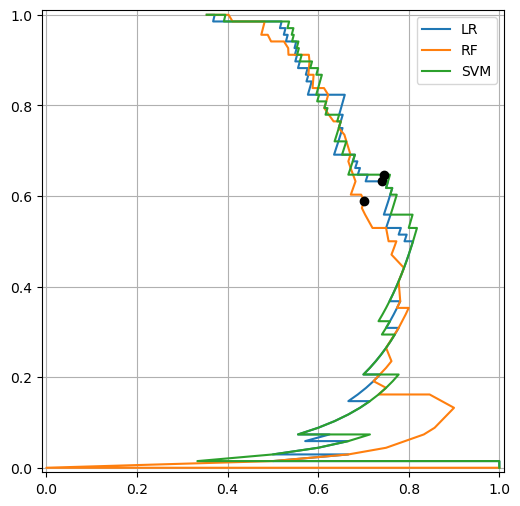

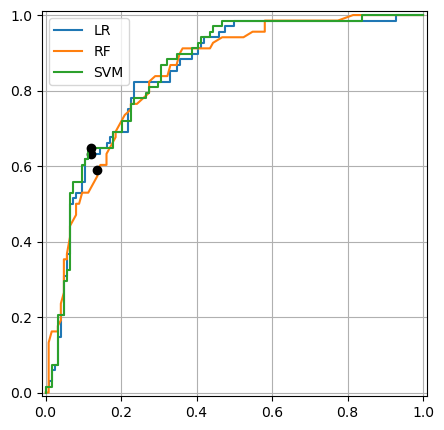

In [99]:
svm_ye = svm_clf.predict(X_test)

svm_cm = confusion_matrix(Y_test, svm_ye)
display(compute_metrics(svm_cm))

svm_y2d = svm_clf.decision_function(X_test)
compare_PR([Y_test, Y_test, Y_test], [lr_cm, rf_cm, svm_cm], [lr_y2d, rf_y2d, svm_y2d], ["LR", "RF", "SVM"])
compare_ROC([Y_test, Y_test, Y_test], [lr_cm, rf_cm, svm_cm], [lr_y2d, rf_y2d, svm_y2d], ["LR","RF", "SVM"])

## Extract Explanations


### <i>Local Model-Agnostic Explanations</i> (LIME)

In [100]:
svm_LIME_explainer = lime.lime_tabular.LimeTabularExplainer(X_train, feature_names=features_names)
svm_LIME_explanation = svm_LIME_explainer.explain_instance(X_test[0], svm_clf.predict_proba)

In [101]:
svm_LIME_explanation.show_in_notebook(show_table=True)

### <i>SHapley Additive exPlanations</i> (SHAP)

In [102]:
svm_SHAP_exp = shap.KernelExplainer(svm_clf.predict_proba, shap.sample(X_train_pd, 100))
svm_shap_values = np.array(svm_SHAP_exp.shap_values(X_test_pd.iloc[0, :]))

In [103]:
shap.force_plot(svm_SHAP_exp.expected_value[1], svm_shap_values[:,1], X_test_pd.iloc[0, :])

  0%|          | 0/192 [00:00<?, ?it/s]

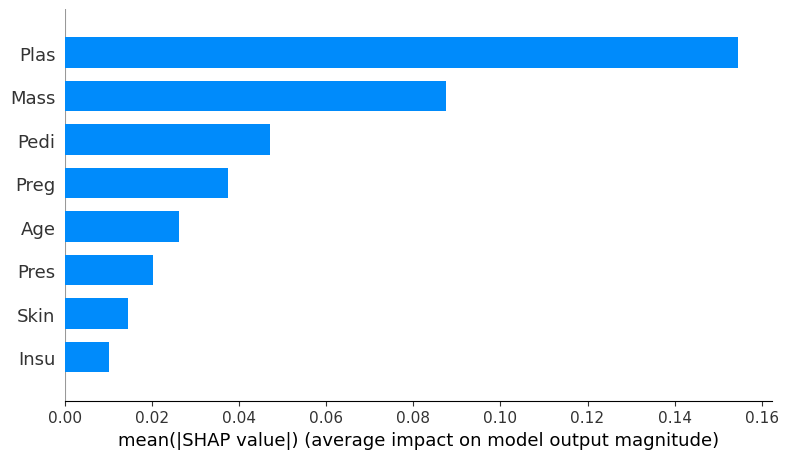

In [104]:
svm_shap_values = np.array(svm_SHAP_exp.shap_values(X_test_pd))
shap.summary_plot(svm_shap_values[:,:,1], X_test_pd, plot_type="bar")

1 5


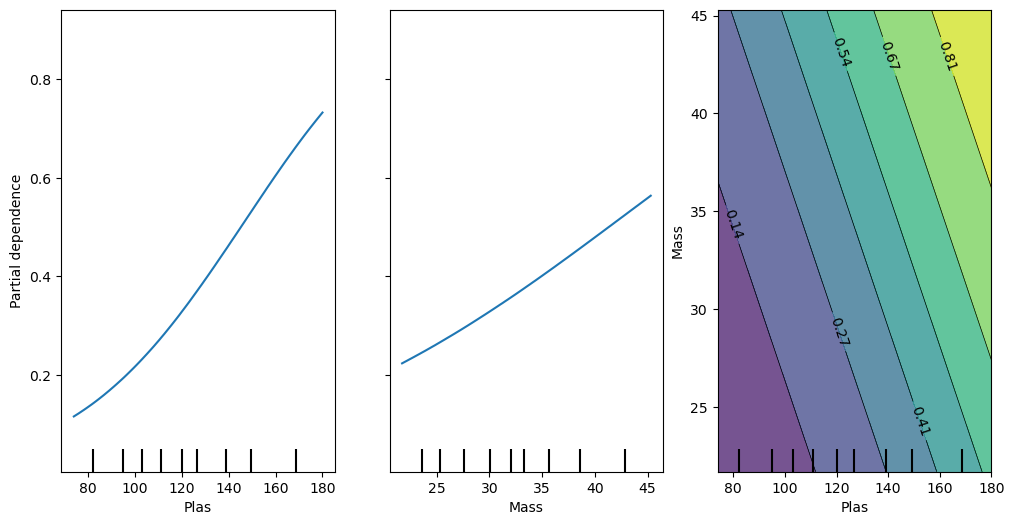

In [106]:
print(f1, f2)
features1 = [f1, f2, (f1, f2)]
fig, ax = plt.subplots(figsize=(12, 6))
PartialDependenceDisplay.from_estimator(svm_clf, X_test, features1, feature_names=features_names, ax=ax)

5 7


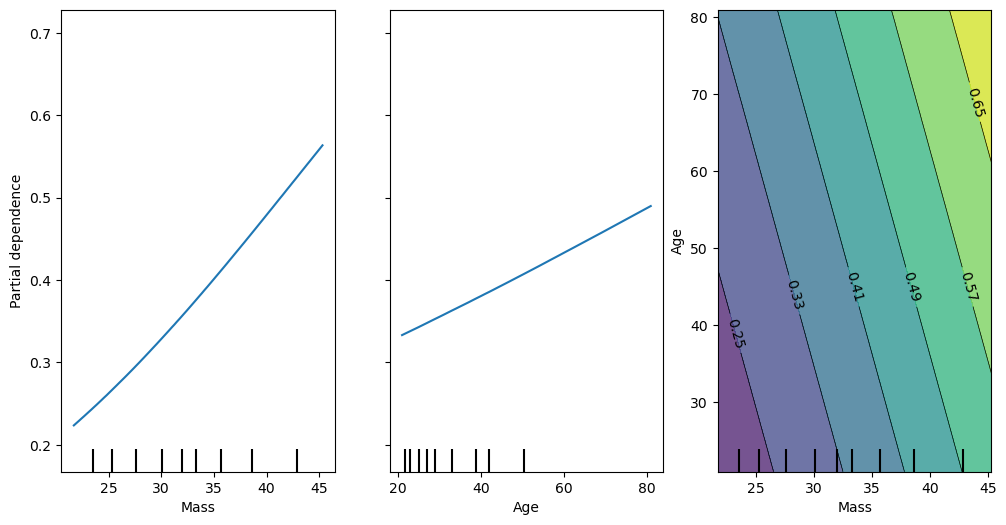

In [107]:
print(f2, f3)
features2 = [f2, f3, (f2, f3)]
fig, ax = plt.subplots(figsize=(12, 6))
PartialDependenceDisplay.from_estimator(svm_clf, X_test, features2, feature_names=features_names, ax=ax)

7 2


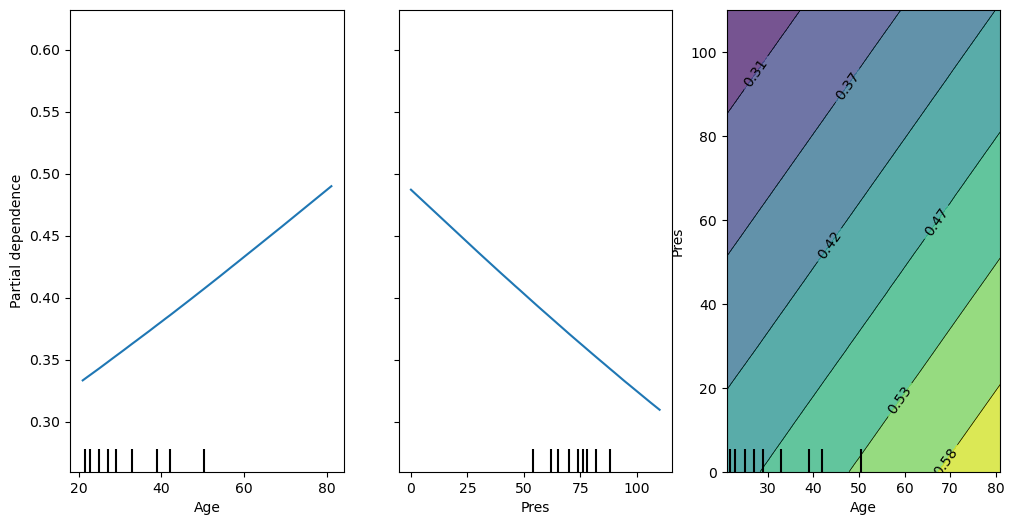

In [108]:
print(f3, f4)
features3 = [f3, f4, (f3, f4)]
fig, ax = plt.subplots(figsize=(12, 6))
PartialDependenceDisplay.from_estimator(svm_clf, X_test, features3, feature_names=features_names, ax=ax)

2 3


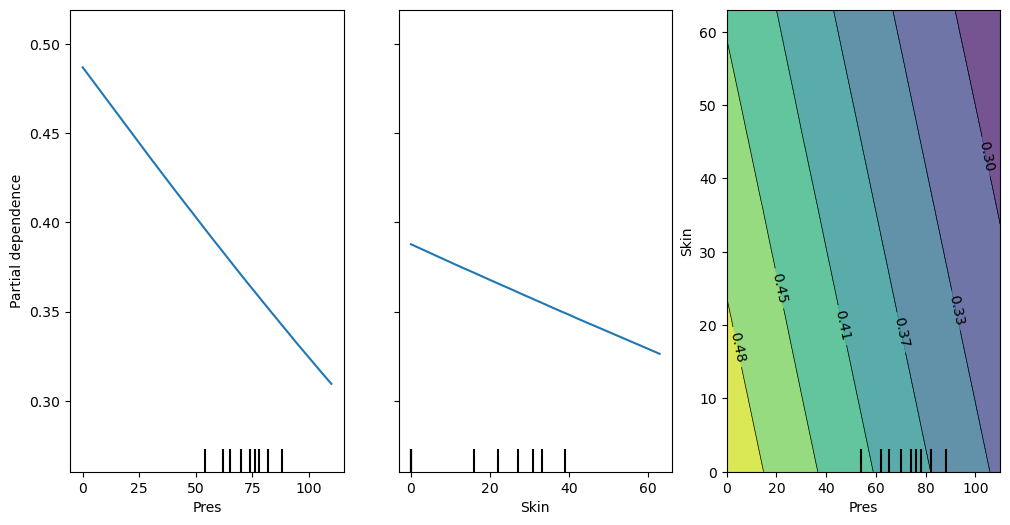

In [109]:
print(f4, f5)
features4 = [f4, f5, (f4, f5)]
fig, ax = plt.subplots(figsize=(12, 6))
PartialDependenceDisplay.from_estimator(svm_clf, X_test, features4, feature_names=features_names, ax=ax)

3 4


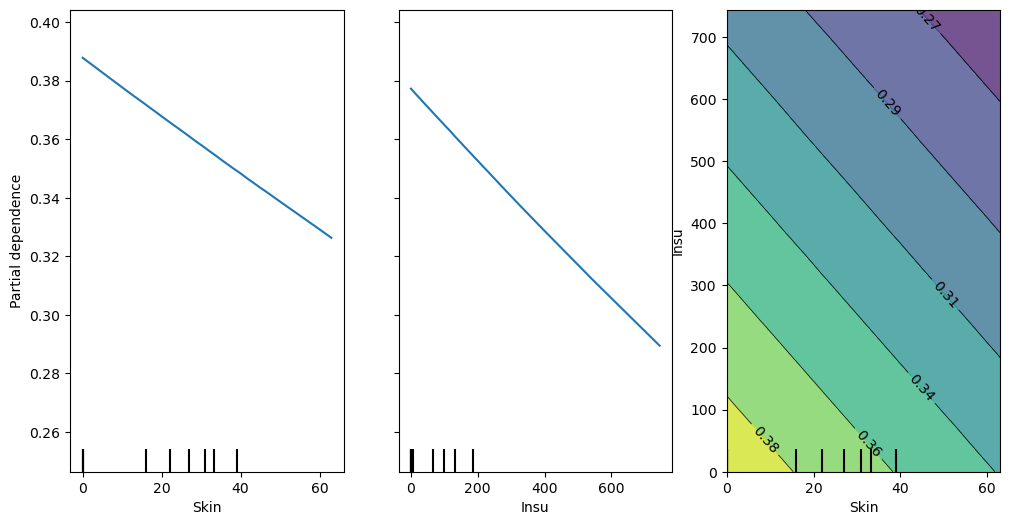

In [110]:
print(f5, f6)
features5 = [f5, f6, (f5, f6)]
fig, ax = plt.subplots(figsize=(12, 6))
PartialDependenceDisplay.from_estimator(svm_clf, X_test, features5, feature_names=features_names, ax=ax)

4 6


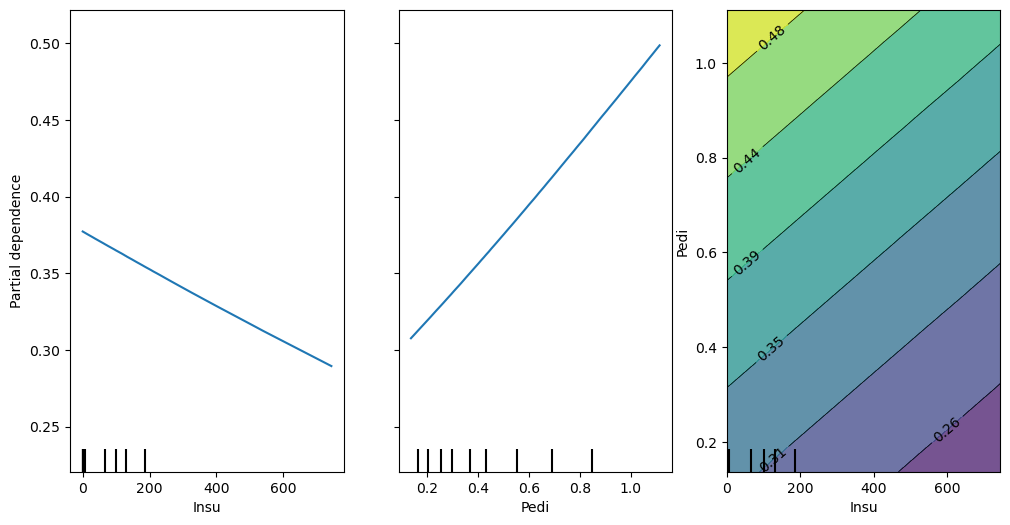

In [111]:
print(f6, f7)
features6 = [f6, f7, (f6, f7)]
fig, ax = plt.subplots(figsize=(12, 6))
PartialDependenceDisplay.from_estimator(svm_clf, X_test, features6, feature_names=features_names, ax=ax)

6 0


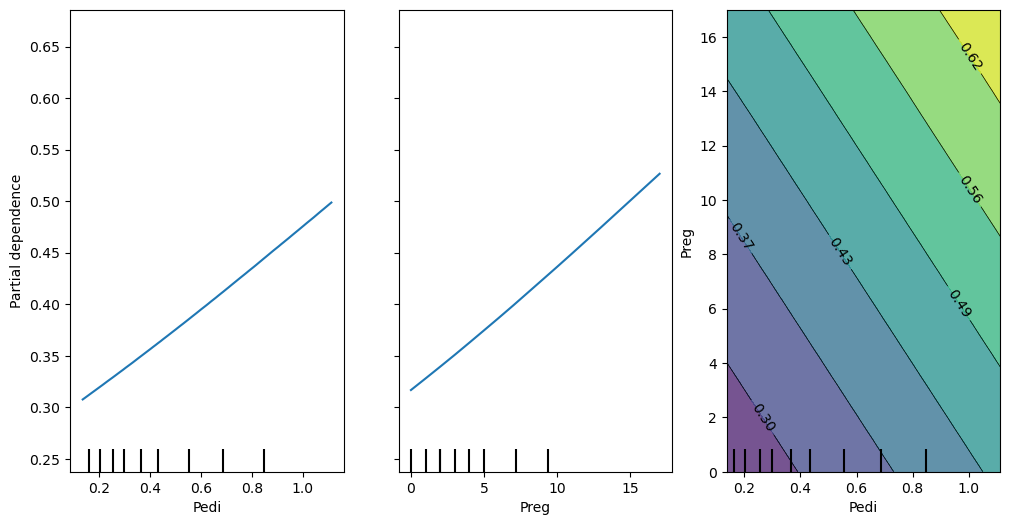

In [116]:
print(f7, f8)
features7 = [f7, f8, (f7, f8)]
fig, ax = plt.subplots(figsize=(12, 6))
PartialDependenceDisplay.from_estimator(svm_clf, X_test, features7, feature_names=features_names, ax=ax)

In [113]:
ebm = ExplainableBoostingClassifier()
ebm.fit(X_train_pd, Y_train)

ebm.score(X_test_pd, Y_test)

0.7552083333333334

In [114]:
ebm_global = ebm.explain_global()
show(ebm_global)

<!-- http://127.0.0.1:7001/2863546310928/ -->

In [115]:
ebm_local = ebm.explain_local(X_test, Y_test)
show(ebm_local)

<!-- http://127.0.0.1:7001/2863511060688/ -->